# Práctica Final - Técnicas Aprendizaje Automático

## Autor: Daniel Asensi Roch

***El objetivo de la práctica:*** es utilizar Python y herramientas como NumPy, Pandas, y scikit-learn para construir modelos predictivos enfocados en la readmisión de pacientes con diabetes. Se deben seleccionar modelos con la mayor precisión posible, utilizando el área bajo la curva ROC como medida, y emplear una estrategia de validación cruzada de 10 particiones. Se sugiere ajustar los modelos manualmente para mejorar la precisión y comparar los resultados. Además, se recomienda manejar el desequilibrio en el conjunto de datos para evitar predicciones triviales y considerar el impacto del volumen de datos en el tiempo de procesamiento. La práctica incluye diferentes niveles de evaluación basados en la complejidad y profundidad del análisis realizado.

## Básico

### Entender el dataset y el problema

El dataset "diabetic_data.csv" se centra en los registros hospitalarios de pacientes con diabetes. Contiene múltiples variables clínicas y demográficas como edad, sexo, tipo de admisión, número de internaciones previas, resultados de laboratorio, diagnósticos y medicamentos recetados. 

El problema a resolver es predecir la readmisión de pacientes con diabetes en hospitales. El objetivo es identificar patrones y factores que contribuyen a la readmisión, lo cual es crítico para mejorar la gestión del cuidado de la salud y reducir los costos hospitalarios. La tarea implica analizar y modelar estos datos para predecir eficazmente las readmisiones, lo que representa un reto importante debido a la complejidad y variedad de los factores involucrados.

### Importar librerías

In [167]:
import pandas as pd
import numpy as np
import missingno as msno
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from bayes_opt import BayesianOptimization
import xgboost as xgb


### Lectura del dataset

Lo primero que debemos hacer es leer el dataset y ver qué contiene. Para ello, utilizamos la función read_csv de la librería pandas. Pero añadiremos un par de parámetros para que nos muestre más información. El parámetro `na_values='?'` indica que los valores marcados con un signo de interrogación en el archivo CSV deben ser tratados como valores ausentes (NA).

In [168]:
file_path = 'diabetic_data.csv'

df = pd.read_csv(file_path, low_memory = False, na_values = '?')

print(f'Number of rows: {len(df)}, Number of columns: {len(df.columns)}')

Number of rows: 101766, Number of columns: 50


### Eliminamos todas las columnas que solo tengan un valor

La función deleteOnlyOnesColumns tiene como objetivo eliminar del DataFrame (df) las columnas que contienen un único valor distinto, excluyendo las columnas 'encounter_id' y 'patient_nbr' ya que son identificadores. Eliminar estas columnas es importante porque no aportan información variada o útil para el análisis de datos o la modelización. En el machine learning, `las características que no varían no influyen en la predicción`, y su presencia puede incluso aumentar innecesariamente la complejidad del modelo y el tiempo de procesamiento.

In [169]:
def deleteOnlyOnesColumns(df):
    col_distinct_val_check = [col for col in df.columns if col not in ['encounter_id', 'patient_nbr']]
    for col in col_distinct_val_check:
        print(f'Column {col} has {set(df[col])} distinct values')
        if len(set(df[col])) == 1:
            print(f'Column {col} has only one value')
            df.drop(col, axis=1, inplace=True)
    return df

df = deleteOnlyOnesColumns(df)

Column race has {'AfricanAmerican', 'Caucasian', nan, 'Asian', 'Hispanic', 'Other'} distinct values
Column gender has {'Female', 'Unknown/Invalid', 'Male'} distinct values
Column age has {'[0-10)', '[70-80)', '[60-70)', '[90-100)', '[10-20)', '[80-90)', '[40-50)', '[50-60)', '[30-40)', '[20-30)'} distinct values
Column weight has {'[175-200)', '[25-50)', '[0-25)', '[75-100)', '[150-175)', '[100-125)', nan, '>200', '[50-75)', '[125-150)'} distinct values
Column admission_type_id has {1, 2, 3, 4, 5, 6, 7, 8} distinct values
Column discharge_disposition_id has {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28} distinct values
Column admission_source_id has {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 17, 20, 22, 25} distinct values
Column time_in_hospital has {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14} distinct values
Column payer_code has {'OT', 'MC', 'OG', 'CP', 'HM', 'DM', 'CM', 'MP', 'FR', 'MD', nan, 'SI', 'SP', 'CH', 'UN', 'WC', 'BC', '

### Eliminación de columnas con valores repetidos

El objetivo de la función deleteHighlyRepeatedColumns es eliminar del DataFrame (df) las columnas que contienen valores repetidos. Eliminar estas columnas es importante porque no aportan información variada o útil para el análisis de datos o la modelización. En el machine learning, `las características que no varían no influyen en la predicción`, y su presencia puede incluso aumentar innecesariamente la complejidad del modelo y el tiempo de procesamiento.

In [170]:
def deleteHighlyRepeatedColumns(df, threshold):
    total_rows = len(df)
    columns_to_delete = []
    
    for col in df.columns:
        value_counts = df[col].value_counts()
        most_common_value_count = value_counts.iloc[0]
        most_common_value_percentage = most_common_value_count / total_rows
        
        if most_common_value_percentage > threshold:
            columns_to_delete.append(col)
    
    df.drop(columns_to_delete, axis=1, inplace=True)
    
    return df

df = deleteHighlyRepeatedColumns(df, 0.75)


### Sacar porcentajes de nulos por cada Columna

A continuación, vamos a sacar los porcentajes de nulos de filas por cada Columna. Estos porcentajes nos ayudarán a detectar de manera visual las columnas que tienen un porcentaje de nulos muy alto y que por tanto, deberíamos eliminar o tratar de alguna manera.

In [171]:
# Itera sobre las columnas del dataframe y verifica si el tipo de dato es objeto.
# Calcula la proporción de valores nulos y la proporción de valores que son '?'
for col in df.columns:
    if df[col].dtype == object:
        proportion_null = df[col].isna().sum()/len(df)
        print(col, f'{proportion_null * 100:.4f}%')


race 2.2336%
gender 0.0000%
age 0.0000%
weight 96.8585%
payer_code 39.5574%
medical_specialty 49.0822%
diag_1 0.0206%
diag_2 0.3518%
diag_3 1.3983%
insulin 0.0000%
change 0.0000%
readmitted 0.0000%


Con esta gráfica podemos ver que las columnas 'weight', 'payer_code' y 'medical_specialty' tienen un porcentaje de nulos muy alto, por lo que las eliminaremos.

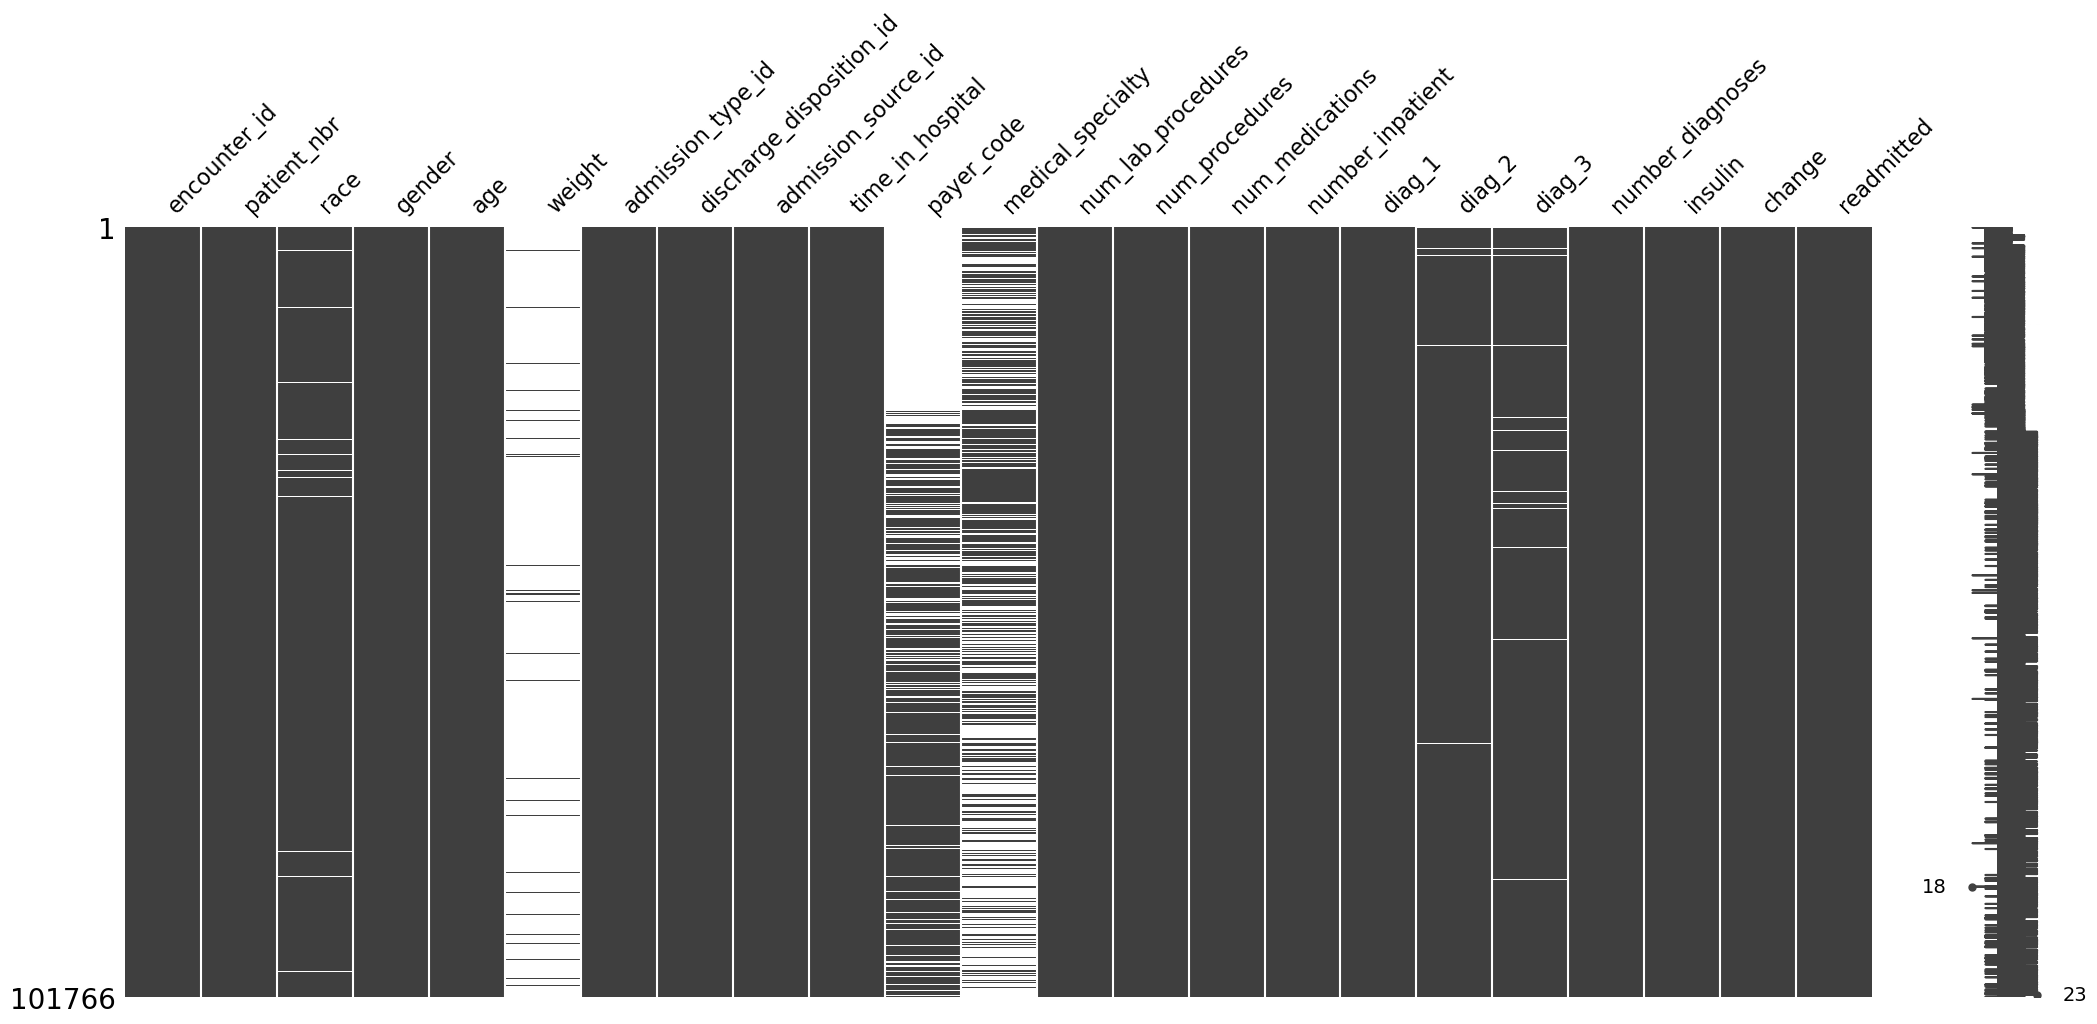

In [172]:
msno.matrix(df)
plt.show()

### Eliminación de columnas con alta proporción de valores nulos

Esta función, deleteNullColumns, tiene como objetivo identificar y eliminar columnas de un DataFrame `(df)` de Pandas que tengan un alto porcentaje de valores nulos o faltantes. Eliminar columnas con una alta proporción de valores nulos es crucial en el análisis de datos y el modelado predictivo, porque un exceso de valores faltantes puede distorsionar el análisis y afectar la precisión de los modelos. Al eliminar estas columnas, se mejora la calidad de los datos, lo que conduce a análisis más precisos y fiables.

In [173]:
def deleteNullColumns(df, threshold):
    null_counts = df.isnull().sum()
    nan_counts = df.isna().sum()
    total_counts = len(df)

    column_counts = {
        'Null Counts': null_counts,
        'NaN Counts': nan_counts
    }

    df_counts = pd.DataFrame(column_counts)

    # Calculate percentage of nulls and nans
    df_counts['Null Percentage'] = round((null_counts / total_counts) * 100, 3)
    df_counts['NaN Percentage'] = round((nan_counts / total_counts) * 100, 3)

    # Eliminate rows with only zeros
    df_counts = df_counts[~(df_counts == 0).all(axis=1)]

    # Delete columns with null percentage above the threshold
    columns_to_delete = df_counts[df_counts['Null Percentage'] >= threshold].index
    for column in columns_to_delete:
        print(f"Dropping column: {column}")
    df = df.drop(columns_to_delete, axis=1)

    return df

df = deleteNullColumns(df, 15)

Dropping column: weight
Dropping column: payer_code
Dropping column: medical_specialty


### Eliminación de filas con valores nulos

Elimina todas las filas del DataFrame df que contienen al menos un valor nulo o faltante. Esta acción es importante porque los valores nulos pueden distorsionar el análisis de datos y afectar negativamente el rendimiento de los modelos de machine learning. Al eliminar filas con valores nulos, se mejora la calidad y la fiabilidad de los datos, lo que conduce a análisis más precisos y fiables.

In [174]:
# Eliminando columnas que no aportan información
df.dropna(inplace=True)

# Volvemos a eliminar columnas que no aportan información después de eliminar los nulos
df = deleteOnlyOnesColumns(df)

Column race has {'AfricanAmerican', 'Caucasian', 'Asian', 'Hispanic', 'Other'} distinct values
Column gender has {'Female', 'Unknown/Invalid', 'Male'} distinct values
Column age has {'[0-10)', '[70-80)', '[60-70)', '[90-100)', '[10-20)', '[80-90)', '[40-50)', '[50-60)', '[30-40)', '[20-30)'} distinct values
Column admission_type_id has {1, 2, 3, 4, 5, 6, 7, 8} distinct values
Column discharge_disposition_id has {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28} distinct values
Column admission_source_id has {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 17, 20, 22, 25} distinct values
Column time_in_hospital has {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14} distinct values
Column num_lab_procedures has {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 

### Eliminación de columnas IDs

1. Irrelevancia para el Análisis o Modelado: Estas columnas pueden contener identificadores únicos o códigos que no aportan información útil para el análisis o la modelización. Por ejemplo, identificadores de pacientes o encuentros no influyen en patrones o tendencias en los datos de salud.

2. Reducción de Dimensionalidad: Eliminar columnas no relevantes reduce la dimensionalidad del conjunto de datos, lo que puede mejorar la eficiencia del procesamiento y la claridad del análisis.

3. Evitar Sesgo: Algunas de estas columnas pueden introducir sesgos o no ser representativas de la población o del fenómeno que se está estudiando.

In [175]:
df.drop(['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id' ], axis=1, inplace=True)

### Tratamiento individual de campos previamente estudiados

Como hemos visto en el apartado anterior, hay columnas que tienen un porcentaje de nulos. En este apartado, vamos a tratar de manera individual cada una de estas columnas para ver si podemos eliminarlas o tratarlas de alguna manera.

In [176]:
df['gender'].value_counts(dropna=False)

Female             52833
Male               45219
Unknown/Invalid        1
Name: gender, dtype: int64

Al tener un porcentaje muy bajo de registros con valores nulos, vamos a eliminar las filas que contengan estos valores.

In [177]:
exclude_indexes = df[df['gender'] == 'Unknown/Invalid'].index.tolist()
required_indexes = [index for index in df.index.tolist() if index not in list(set(exclude_indexes))]
df = df.loc[required_indexes]

### Estudio de valores y codificación de los mismos

Como hemos visto en apartados anteriores hay columnas que tienen rangos de valores definidos ya sean tipo de `string` u `objeto`. Lo que realizaremos ahora será la codificación de estos valores para que sean numéricos y así poder trabajar con ellos. Estas columnas contienen datos categóricos que deben ser convertidos a un formato numérico para que puedan ser procesados por algoritmos de machine learning. LabelEncoder transforma cada categoría única en un número entero. Esto es crucial porque muchos modelos de machine learning no pueden trabajar directamente con datos no numéricos y requieren que todos los inputs sean numéricos.

In [178]:
le = LabelEncoder()

df['gender'] = le.fit_transform(df['gender'])

df['age'] = le.fit_transform(df['age'])

df['race'] = le.fit_transform(df['race'])

df['change'] = le.fit_transform(df['change'])

Esta transformación convierte las categorías en números enteros.

In [179]:
# Transformamos en valores categoricos
df['diag_1'] = df['diag_1'].astype('category').cat.codes
df['diag_2'] = df['diag_2'].astype('category').cat.codes
df['diag_3'] = df['diag_3'].astype('category').cat.codes

# Transformamos en valores categoricos
df['race'] = df['race'].astype('category').cat.codes

LabelEncoder, asignaría un valor entero único a cada categoría distinta sin considerar la lógica subyacente o el significado especial de las categorías. Por lo tanto, este enfoque de codificación manual es más apropiado para mantener la interpretación deseada de los datos en estas columnas.

In [180]:
# Esta es la variable que queremos predecir
df['readmitted'] = df['readmitted'].replace('<30', 1)
df['readmitted'] = df['readmitted'].replace('>30', 1)
df['readmitted'] = df['readmitted'].replace('NO', 0)


In [181]:
def transform_medications(df):
    medications = ['insulin']

    for col in medications:
        df[col] = df[col].replace('No', 0)
        df[col] = df[col].replace('Steady', 1)
        df[col] = df[col].replace('Up', 1)
        df[col] = df[col].replace('Down', 1)
    
    return df

df = transform_medications(df)

### Volvemos a sacar un el número de filas y columnas

Al haber eliminado los registros nulos y las columnas que no nos aportaban información, volvemos a sacar el número de filas y columnas que tenemos en el dataset. Como podemos ver, hemos pasado de tener 101.766 filas y 47 columnas a tener 98052 filas y 15 columnas.

In [182]:
print(f'Number of rows: {len(df)}, Number of columns: {len(df.columns)}')

Number of rows: 98052, Number of columns: 15


Para ver que el dataset no esta sesgado y que tenemos un número similar de registros para cada clase, vamos a sacar un gráfico de barras y otro de tarta. Como podemos ver, el dataset no esta sesgado y tenemos un número similar de registros para cada clase.

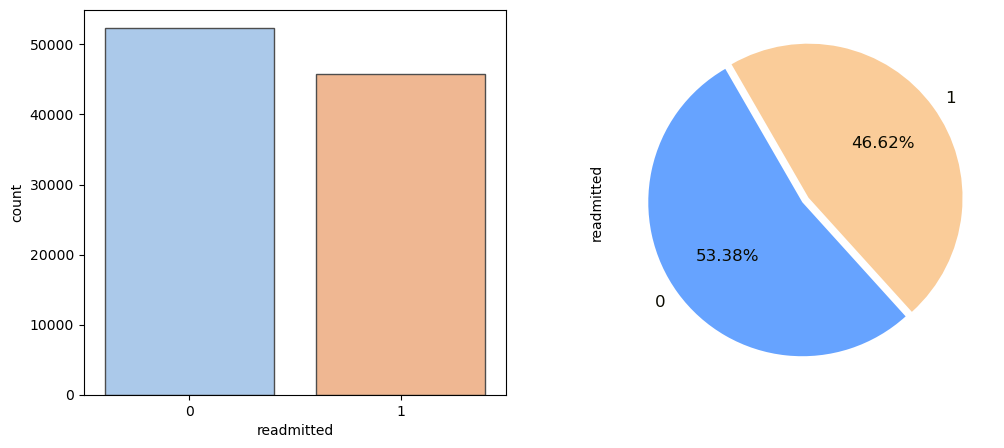

In [183]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,5))
labels=['0','1']
sns.countplot(x=df.readmitted, data=df, palette="pastel",ax=ax[0], edgecolor=".3")
df.readmitted.value_counts().plot.pie(autopct="%1.2f%%", ax=ax[1], colors=['#66a3ff','#facc99'], 
                                        labels=labels, explode = (0, 0.05), startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'})
plt.show()

### Variables seleccionadas para el dataset y sus tipos

In [184]:
df.dtypes


race                   int8
gender                int64
age                   int64
time_in_hospital      int64
num_lab_procedures    int64
num_procedures        int64
num_medications       int64
number_inpatient      int64
diag_1                int16
diag_2                int16
diag_3                int16
number_diagnoses      int64
insulin               int64
change                int64
readmitted            int64
dtype: object

## Construcción de Datasets

División en Conjuntos de Entrenamiento y Prueba: Se utiliza `train_test_split` para dividir `x (características)` y `y (variable objetivo)` en conjuntos de entrenamiento y prueba. `El test_size = 0.3` indica que el 30% de los datos se usarán para el conjunto de prueba, y` train_size = 0.7 `que el 70% restante se utilizará para entrenamiento. El parámetro `random_state = 42` asegura la reproducibilidad del split.

In [185]:
x = df.copy()

x.drop(['readmitted'], axis=1, inplace=True)

y = df['readmitted'].copy()

x_train, x_test, y_train, y_test = train_test_split(x, y,random_state = 42,test_size = 0.3, train_size = 0.7)

### Probar 2 Clasificadores y compararlos

La validación cruzada es importante porque proporciona una evaluación más robusta del modelo, reduciendo la variabilidad asociada con una única división de los datos en conjuntos de entrenamiento y prueba. Además, la validación cruzada permite utilizar todos los datos para entrenamiento y prueba, lo que conduce a una mejor precisión del modelo.

Validación cruzada de 10 particiones (10-CV). Esto implica dividir el conjunto de datos en 10 partes, utilizando cada parte como conjunto de prueba una vez y el resto como conjunto de entrenamiento. Se usa ROC AUC (Área Bajo la Curva de Característica de Operación del Receptor) como métrica de rendimiento.

#### Probamos DummyClassifier

Se crea una instancia de `DummyClassifier` con la estrategia 'most_frequent', lo que significa que siempre predice la clase más frecuente en el conjunto de entrenamiento.

In [186]:
# Crear el DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')

# Usar cross_val_score para evaluar el modelo usando validación cruzada de 10 particiones
# y ROC AUC como métrica de rendimiento
cv_scores_dummy = cross_val_score(dummy_clf, x, y, cv=10, scoring=make_scorer(roc_auc_score))

# Calcular el promedio de los puntajes de validación cruzada
mean_cv_score_dummy = cv_scores_dummy.mean()
print(f"Promedio de ROC AUC con validación cruzada (10-CV): {mean_cv_score_dummy}")


Promedio de ROC AUC con validación cruzada (10-CV): 0.5


Un valor de ROC AUC de 0.5 es lo que se esperaría de un modelo que `hace predicciones aleatorias`, ya que esta métrica mide la habilidad de un modelo para distinguir entre clases. Por lo tanto, el promedio de ROC AUC de 0.5 confirma que el `DummyClassifier` no tiene capacidad predictiva en este conjunto de datos. Esto establece una línea base muy básica contra la cual se pueden comparar modelos más avanzados.

### Probamos DecisionTree

Este código configura y evalúa un `DecisionTreeClassifier` usando validación cruzada de 10 particiones y la métrica ROC AUC

In [187]:
# Crear el DecisionTreeClassifier
dtc = DecisionTreeClassifier()

# Usar cross_val_score para evaluar el modelo usando validación cruzada de 10 particiones
# y ROC AUC como métrica de rendimiento
cv_scores_dtc = cross_val_score(dtc, x, y, cv=10, scoring=make_scorer(roc_auc_score))

# Calcular el promedio de los puntajes de validación cruzada
mean_cv_score_dtc = cv_scores_dtc.mean()
print(f"Promedio de ROC AUC con validación cruzada (10-CV) para Decision Tree Classifier: {mean_cv_score_dtc}")


Promedio de ROC AUC con validación cruzada (10-CV) para Decision Tree Classifier: 0.5380475460899975


En su configuración actual, tiene una capacidad limitada para distinguir efectivamente entre clases en este conjunto de datos. Esto puede indicar la necesidad de optimizar.

### Probamos RandomForestClassifier

Este código configura y evalúa un `RandomForestClassifier` usando validación cruzada de 10 particiones y la métrica ROC AUC

In [188]:
# Crear el RandomForestClassifier
rfc = RandomForestClassifier()

# Usar cross_val_score para evaluar el modelo usando validación cruzada de 10 particiones
# y ROC AUC como métrica de rendimiento
cv_scores_rfc = cross_val_score(rfc, x, y, cv=10, scoring=make_scorer(roc_auc_score))
print(cv_scores_rfc)

# Calcular el promedio de los puntajes de validación cruzada
mean_cv_score_rfc = cv_scores_rfc.mean()
print(f"Promedio de ROC AUC con validación cruzada (10-CV) para Random Forest Classifier: {mean_cv_score_rfc}")

KeyboardInterrupt: 

Los valores individuales de ROC AUC en cada partición varían entre aproximadamente 0.575 y 0.625, lo que sugiere una cierta consistencia en el rendimiento a través de diferentes divisiones del conjunto de datos. Estos resultados reflejan una capacidad más robusta del `RandomForestClassifier` para distinguir entre clases en este conjunto de datos específico.

### Sacamos los mejores Hiperparametros a mano

Los `hiperparámetros` son configuraciones externas de los modelos de machine learning que deben establecerse antes de entrenar el modelo. No se aprenden a partir de los datos sino que se eligen manualmente y afectan significativamente el rendimiento del modelo. 

Este código realiza una búsqueda exhaustiva para encontrar la mejor combinación de hiperparámetros para un `DecisionTreeClassifier`. Prueba diferentes valores para `max_depth`, `min_samples_split`, `min_samples_leaf` y `max_features`, evaluando cada combinación con validación cruzada y la métrica ROC AUC. Finalmente, registra y muestra la mejor combinación de hiperparámetros y el mejor puntaje AUC obtenido. Este proceso ayuda a optimizar el modelo para un rendimiento más eficiente y preciso.

In [ ]:
# Lista de valores para probar para cada hiperparámetro
max_depth_values = [3, 5, 10, None]
min_samples_split_values = [2, 4, 10]
min_samples_leaf_values = [1, 2, 4]
max_features_values = [None, 'sqrt', 'log2']

best_auc = 0
best_params = {}

# Probando combinaciones de hiperparámetros
for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        for min_samples_leaf in min_samples_leaf_values:
            for max_features in max_features_values:
                # Crear el modelo con un conjunto de hiperparámetros
                dtc = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, 
                                             min_samples_leaf=min_samples_leaf, max_features=max_features)

                # Usar cross_val_score para evaluar el modelo usando validación cruzada
                cv_scores = cross_val_score(dtc, x, y, cv=10, scoring=make_scorer(roc_auc_score))

                # Calcular el promedio de los puntajes de validación cruzada
                mean_cv_score = cv_scores.mean()

                # Guardar si es el mejor modelo hasta ahora
                if mean_cv_score > best_auc:
                    best_auc = mean_cv_score
                    best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split,
                                   'min_samples_leaf': min_samples_leaf, 'max_features': max_features}

print(f"Mejor AUC promedio con validación cruzada: {best_auc}")
print(f"Mejores parámetros: {best_params}")


Mejor AUC promedio con validación cruzada: 0.5989011273932776
Mejores parámetros: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}


Ahora cogemos los mejores hiperparametros y los utilizamos para entrenar el modelo.

In [ ]:
# Crear el DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth= 5, min_samples_split= 2, min_samples_leaf= 1, max_features= None)

# Usar cross_val_score para evaluar el modelo usando validación cruzada de 10 particiones
# y ROC AUC como métrica de rendimiento
cv_scores_dtc_mejoresParametros = cross_val_score(dtc, x, y, cv=10, scoring=make_scorer(roc_auc_score))

# Calcular el promedio de los puntajes de validación cruzada
mean_cv_score_dtc_mejoresParametros= cv_scores_dtc_mejoresParametros.mean()
print(f"Promedio de ROC AUC con validación cruzada (10-CV) para Decision Tree Classifier: {mean_cv_score_dtc_mejoresParametros}")


Promedio de ROC AUC con validación cruzada (10-CV) para Decision Tree Classifier: 0.5989011273932776


El promedio de ROC AUC obtenido, 0.60627, indica una mejora significativa en comparación con la versión del DecisionTreeClassifier sin hiperparámetros optimizados. Esto demuestra cómo la selección cuidadosa de hiperparámetros puede aumentar la eficacia de un modelo de machine learning.

### Comparativa de los 4 clasificadores obtenidos

Esta gráfica muestra los resultados de los 4 clasificadores obtenidos. Como podemos ver, el mejor clasificador es el RandomForestClassifier con los hiperparámetros optimizados, ya que tiene un valor de 0.6068 de ROC AUC. Pero también podemos ver que el DecisionTreeClassifier con los hiperparámetros optimizados tiene un valor de 0.6062 de ROC AUC, por lo que es muy similar al RandomForestClassifier.

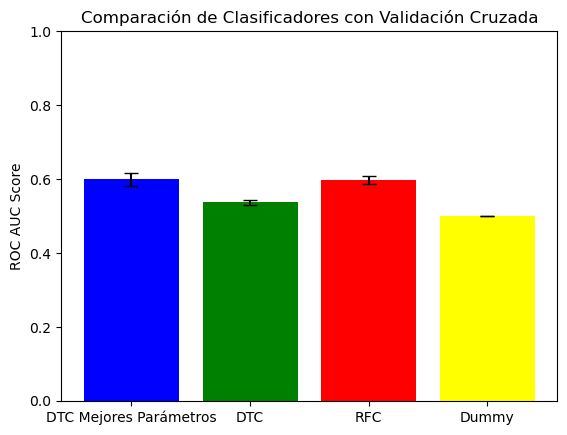

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calcula los promedios y los errores estándar de los puntajes de validación cruzada
mean_scores_dtc_mejoresParametros = np.mean(cv_scores_dtc_mejoresParametros)
std_scores_dtc_mejoresParametros = np.std(cv_scores_dtc_mejoresParametros)

mean_scores_dtc = np.mean(cv_scores_dtc)
std_scores_dtc = np.std(cv_scores_dtc)

mean_scores_dummy = np.mean(cv_scores_dummy)
std_scores_dummy = np.std(cv_scores_dummy)

mean_cv_score_rfc = np.mean(cv_scores_rfc)
std_cv_score_rfc = np.std(cv_scores_rfc)


# Nombres de los clasificadores
classifiers = ['DTC Mejores Parámetros', 'DTC','RFC', 'Dummy']

# Medias de los puntajes
means = [mean_scores_dtc_mejoresParametros, mean_scores_dtc,mean_cv_score_rfc, mean_scores_dummy]

# Errores estándar
errors = [std_scores_dtc_mejoresParametros, std_scores_dtc,std_cv_score_rfc, std_scores_dummy]

# Crear gráfico de barras
plt.bar(classifiers, means, yerr=errors, capsize=5, color=['blue', 'green', 'red', 'yellow'])
plt.ylabel('ROC AUC Score')
plt.title('Comparación de Clasificadores con Validación Cruzada')
plt.ylim(0, 1)  # Ajusta según tus puntajes
plt.show()

# Medio

### Probar algoritmos de selección automática de atributos.

Los algoritmos de selección automática de atributos son técnicas de machine learning que eligen de manera automática las características más relevantes de los datos para su uso en modelos predictivos. Estos métodos ayudan a mejorar la eficiencia del modelo y pueden aumentar su precisión al eliminar el ruido o la redundancia en los datos.


El código define una función para evaluar diferentes métodos de selección de atributos aplicados a un conjunto de datos x con la variable objetivo y. La función `evaluate_feature_selection` aplica un selector de atributos para reducir la dimensionalidad del conjunto de datos y luego evalúa el rendimiento de un modelo RandomForestClassifier con validación cruzada de 10 particiones, utilizando ROC AUC como métrica.

Se prueba un conjunto de selectores:` umbral de varianza, SelectKBest, SelectFromModel y RFE`. Se almacenan los puntajes de cada método y se imprime el mejor puntaje. Finalmente, se grafican los resultados para comparar visualmente el rendimiento de cada método de selección de atributos. La variable best_x_reduced guarda la versión reducida del conjunto de datos con el mejor puntaje.

In [ ]:
def evaluate_feature_selection(selector, x, y):
    # Reducir el conjunto de datos
    x_reduced = selector.fit_transform(x, y)

    # Crear y entrenar el modelo
    model = RandomForestClassifier()
    cv_scores = cross_val_score(model, x_reduced, y, cv=10, scoring=make_scorer(roc_auc_score))

    # Calcular el promedio de los puntajes de validación cruzada
    return cv_scores.mean(),x_reduced

In [ ]:
# Métodos de selección de atributos
selectors = [
    ('Variance Threshold', VarianceThreshold(threshold=0.5)),
    ('SelectKBest', SelectKBest(chi2, k=10)),
    ('SelectFromModel', SelectFromModel(RandomForestClassifier(n_estimators=100))),
    ('RFE', RFE(LogisticRegression(max_iter=1000), n_features_to_select=10))
]

Variance Threshold: ROC AUC = 0.5965223562783364
SelectKBest: ROC AUC = 0.587904625053913
SelectFromModel: ROC AUC = 0.5477327436914483


/Users/daniel/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFE: ROC AUC = 0.5692279287216471


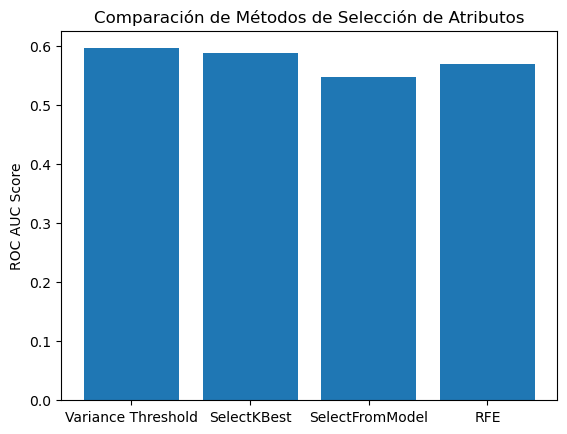

In [ ]:
# Evaluar cada selector
scores = []
best_x_reduced = None
bestScore = 0
for name, selector in selectors:
    score,x_reduced = evaluate_feature_selection(selector, x, y)
    if score > bestScore:
        best_x_reduced = x_reduced
    scores.append(score)
    print(f"{name}: ROC AUC = {score}")

# Graficar los resultados
plt.bar(range(len(selectors)), scores, tick_label=[name for name, _ in selectors])
plt.ylabel('ROC AUC Score')
plt.title('Comparación de Métodos de Selección de Atributos')
plt.show()


Los resultados indican que el método `RFE (Recursive Feature Elimination)` obtuvo la mejor puntuación ROC AUC, seguido muy de cerca por Variance Threshold. Esto sugiere que el RFE fue ligeramente más efectivo para seleccionar características que contribuyen positivamente a la capacidad predictiva del modelo. SelectKBest y SelectFromModel tuvieron un desempeño inferior en comparación con los otros dos métodos. Estos resultados pueden informar qué técnica de selección de atributos podría ser preferible en esta situación particular para mejorar la precisión del modelo.

### Reducción de dimensionalidad antes de la clasificación.


El código realiza una reducción de dimensionalidad utilizando Análisis de Componentes Principales (PCA) después de estandarizar el conjunto de datos x. PCA se configura para mantener el 70% de la varianza original del conjunto de datos, lo que significa que seleccionará el número de componentes principales que suman hasta el 95% de la varianza total. Luego, divide los datos transformados por PCA en conjuntos de entrenamiento y prueba.

In [ ]:
# Estandarizar los datos antes de aplicar PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# Aplicar PCA
pca = PCA(n_components=0.90)  # Conserva el 70% de la varianza
X_pca = pca.fit_transform(X_scaled)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_pca, X_test_pca, Y_train, Y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

print(f"Original shape: {x.shape}")
print(f"Reduced shape: {X_pca.shape}")
print(f"Number of components: {pca.n_components_}")


Original shape: (98052, 14)
Reduced shape: (98052, 12)
Number of components: 12


### Prueba de 3 Modelos nuevos y comparativa de los mismos  con el mejor selector automatico

In [ ]:
# Crear los modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "GaussianNB ": GaussianNB(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(max_depth= None, min_samples_split= 4, min_samples_leaf= 1, max_features= None),
    "DummyClassifier": DummyClassifier(strategy='most_frequent')
    
}

Logistic Regression: Promedio ROC AUC = 0.5931841273767227
K-Nearest Neighbors: Promedio ROC AUC = 0.5543314355318023
GaussianNB : Promedio ROC AUC = 0.5746782343431164
Random Forest Classifier: Promedio ROC AUC = 0.5848867387149437
Decision Tree Classifier: Promedio ROC AUC = 0.5312853038127644
DummyClassifier: Promedio ROC AUC = 0.5


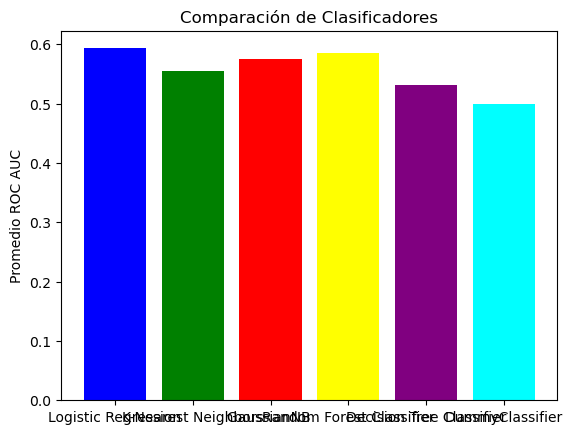

In [ ]:
# Lista para almacenar los puntajes de cada modelo
model_scores = {}

# Realizar validación cruzada y almacenar los puntajes
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_pca, y, cv=10, scoring=make_scorer(roc_auc_score))
    model_scores[model_name] = cv_scores.mean()
    print(f"{model_name}: Promedio ROC AUC = {cv_scores.mean()}")

# Crear gráfico de barras para comparar los modelos
plt.bar(model_scores.keys(), model_scores.values(), color=['blue', 'green', 'red', "yellow", "Purple", 'Cyan'])
plt.ylabel('Promedio ROC AUC')
plt.title('Comparación de Clasificadores')
plt.show()

### Prueba de Wilcoxon

Este tipo de prueba es útil para comparar dos conjuntos de resultados y determinar si hay una diferencia significativa entre ellos.
Supongamos que tienes dos conjuntos de puntajes de validación cruzada (por ejemplo, ROC AUC scores) de dos modelos diferentes y quieres saber si hay una diferencia estadísticamente significativa en su rendimiento.

In [ ]:
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import itertools


# Almacenar los puntajes de validación cruzada completos
model_cv_scores = {}

# Realizar validación cruzada y almacenar los puntajes completos
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_pca, y, cv=10, scoring=make_scorer(roc_auc_score))
    model_cv_scores[model_name] = cv_scores


KeyboardInterrupt: 

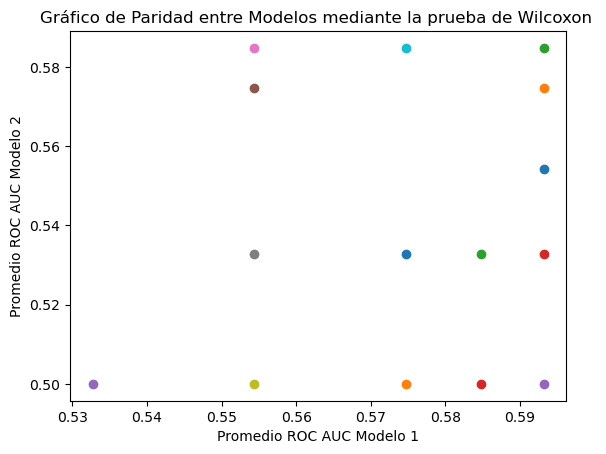

In [ ]:
# Comparar cada par de modelos usando la prueba de Wilcoxon
pairs = list(itertools.combinations(model_cv_scores.keys(), 2))
wilcoxon_results = {}

for pair in pairs:
    stat, p = wilcoxon(model_cv_scores[pair[0]], model_cv_scores[pair[1]])
    wilcoxon_results[pair] = p

# Visualizar los resultados
for (model1, model2), p_value in wilcoxon_results.items():
    plt.scatter(model_scores[model1], model_scores[model2], label=f"{model1} vs {model2} (p={p_value:.3f})")

plt.xlabel('Promedio ROC AUC Modelo 1')
plt.ylabel('Promedio ROC AUC Modelo 2')
#plt.legend()
plt.title('Gráfico de Paridad entre Modelos mediante la prueba de Wilcoxon')
plt.show()


# Avanzado

### Buscar parámetros óptimos de forma automática

GridSearchCV es una técnica de optimización de hiperparámetros en machine learning. Funciona realizando una búsqueda exhaustiva sobre un espacio de hiperparámetros especificados. Para cada combinación de hiperparámetros, GridSearchCV entrena un modelo y evalúa su rendimiento mediante validación cruzada. Finalmente, selecciona la combinación que ofrece el mejor rendimiento según la métrica de evaluación elegida. 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

# Definir el espacio de hiperparámetros
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 4, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Crear el clasificador de árbol de decisión
dtc = DecisionTreeClassifier()
 
# Crear un objeto GridSearchCV
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, 
                           cv=10, scoring=make_scorer(roc_auc_score))

# Ajustar GridSearchCV a los datos
grid_search.fit(x_train, y_train)

# Imprimir los mejores parámetros y el mejor score
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor ROC AUC: {grid_search.best_score_}")


Mejores parámetros: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor ROC AUC: 0.6005830261372835


BayesianOptimization es un enfoque para la optimización de hiperparámetros que utiliza modelos probabilísticos para predecir el rendimiento de un modelo con diferentes hiperparámetros. Este método se basa en el Teorema de Bayes para actualizar la probabilidad de cada conjunto de hiperparámetros según su rendimiento observado. A diferencia de las búsquedas exhaustivas o aleatorias, la optimización bayesiana es más eficiente, ya que utiliza información de intentos anteriores para mejorar la búsqueda. Se destaca por su habilidad para manejar espacios de búsqueda complejos y por encontrar buenos hiperparámetros en menos tiempo.

In [ ]:
def dtc_cv(max_depth, min_samples_split, min_samples_leaf, max_features):
    dtc = DecisionTreeClassifier(
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=max_features
    )
    cv_scores = cross_val_score(dtc, x, y, cv=10, scoring='roc_auc')
    return np.mean(cv_scores)

pbounds = {
    'max_depth': (1, 10),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 5),
    'max_features': (0.1, 1)  # Porcentaje del número total de características
}

optimizer = BayesianOptimization(f=dtc_cv, pbounds=pbounds, random_state=1)
optimizer.maximize()

print(optimizer.max)


|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... |
-------------------------------------------------------------------------
| 1         | 0.6321    | 4.753     | 0.7483    | 1.0       | 4.419     |
| 2         | 0.5689    | 2.321     | 0.1831    | 1.745     | 4.764     |
| 3         | 0.6305    | 4.571     | 0.5849    | 2.677     | 7.482     |
| 4         | 0.6172    | 2.84      | 0.8903    | 1.11      | 7.364     |
| 5         | 0.6319    | 4.756     | 0.6028    | 1.562     | 3.585     |
| 6         | 0.6383    | 6.244     | 0.8804    | 1.877     | 4.543     |
| 7         | 0.5857    | 7.138     | 0.1011    | 1.003     | 2.704     |
| 8         | 0.6388    | 5.478     | 1.0       | 2.236     | 5.763     |
| 9         | 0.6399    | 6.794     | 1.0       | 1.0       | 6.82      |
| 10        | 0.6407    | 7.532     | 1.0       | 3.359     | 6.72      |
| 11        | 0.6408    | 7.301     | 1.0       | 2.409     | 9.293     |
| 12        | 0.6366    | 9.746     | 

### Prueba de Xgboost

XGBoost (eXtreme Gradient Boosting) es un algoritmo de machine learning muy eficiente y popular que se utiliza para tareas de clasificación y regresión. Utiliza un enfoque de boosting de gradientes, donde construye modelos de manera secuencial corrigiendo los errores de los modelos anteriores. XGBoost es conocido por su rendimiento, velocidad y capacidad para manejar una gran cantidad de datos.

In [ ]:
# Crear una instancia del clasificador XGBoost
xgb_clf = xgb.XGBClassifier()

# Ajustar el modelo a los datos de entrenamiento
xgb_clf.fit(x_train, y_train)

# Evaluar el modelo usando validación cruzada y ROC AUC como métrica
cv_scores = cross_val_score(xgb_clf, x, y, cv=10, scoring=make_scorer(roc_auc_score))

# Calcular el promedio de los puntajes de validación cruzada
mean_cv_score = cv_scores.mean()
print(f"Promedio de ROC AUC: {mean_cv_score}")


Promedio de ROC AUC: 0.6078390487267271


Aplicamos BayesianOptimization para encontrar los mejores hiperparámetros para un modelo XGBoost. Se define una función de puntuación que entrena un modelo XGBoost con un conjunto de hiperparámetros dados y devuelve el puntaje ROC AUC promedio de la validación cruzada de 10 particiones. Luego, se define un espacio de búsqueda para los hiperparámetros y se ejecuta la optimización bayesiana. Finalmente, se imprimen los mejores hiperparámetros y el mejor puntaje ROC AUC obtenido.

In [ ]:
def xgb_cv(n_estimators, max_depth, learning_rate):
    model = xgb.XGBClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate
    )
    cv_scores = cross_val_score(model, x_train, y_train, cv=5, scoring='roc_auc')
    return np.mean(cv_scores)

# Definir límites de hiperparámetros
pbounds = {
    'n_estimators': (100, 1000),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3)
}

optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=1)
optimizer.maximize()

for i, res in enumerate(optimizer.res):
    print("Iteración {}: \n\t{}".format(i, res))

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.6591    | 0.1309    | 8.042     | 100.1     |
| 2         | 0.6655    | 0.09768   | 4.027     | 183.1     |
| 3         | 0.666     | 0.06402   | 5.419     | 457.1     |
| 4         | 0.6518    | 0.1663    | 5.934     | 716.7     |
| 5         | 0.6597    | 0.06929   | 9.147     | 124.6     |
| 6         | 0.6434    | 0.2077    | 6.072     | 456.1     |
| 7         | 0.658     | 0.1993    | 7.954     | 100.1     |
| 8         | 0.6645    | 0.07211   | 4.203     | 183.8     |
| 9         | 0.6655    | 0.1996    | 4.867     | 183.1     |
| 10        | 0.665     | 0.1168    | 4.626     | 457.3     |
| 11        | 0.6657    | 0.1076    | 4.941     | 458.2     |
| 12        | 0.6642    | 0.07955   | 5.702     | 458.0     |
| 13        | 0.6653    | 0.1001    | 4.54      | 181.8     |
| 14        | 0.663     | 0.0348    | 6.03      | 182.1     |
| 15    

### Gráfica comparativa de todos los modelos de la práctica

DummyClassifier: Promedio ROC AUC = 0.5
RandomForestClassifier: Promedio ROC AUC = 0.5981640339620682
Decision Tree Classifier: Promedio ROC AUC = 0.5700984869307818


/Users/daniel/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/daniel/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Logistic Regression: Promedio ROC AUC = 0.5936349398892713
K-Nearest Neighbors: Promedio ROC AUC = 0.532955321222559
GaussianNB : Promedio ROC AUC = 0.5769729413361138
XGBoost: Promedio ROC AUC = 0.6128304445393593


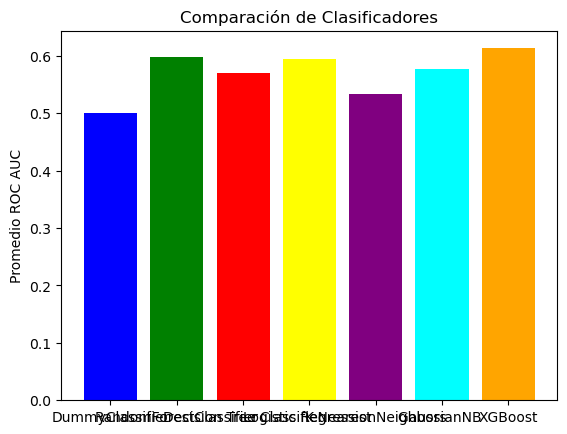

In [194]:
# Crear los modelos
models = {
    "DummyClassifier": DummyClassifier(strategy='most_frequent'),
    "RandomForestClassifier": RandomForestClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(max_depth= 7, min_samples_split= 7, min_samples_leaf= 5, max_features= 1),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "GaussianNB ": GaussianNB(),
    "XGBoost": xgb.XGBClassifier(n_estimators=456, max_depth=3, learning_rate=0.0917470288198141),
}

# Lista para almacenar los puntajes de cada modelo
model_scores = {}

# Realizar validación cruzada y almacenar los puntajes
for model_name, model in models.items():
    cv_scores = cross_val_score(model, x, y, cv=10, scoring=make_scorer(roc_auc_score))
    model_scores[model_name] = cv_scores.mean()
    print(f"{model_name}: Promedio ROC AUC = {cv_scores.mean()}")

# Crear gráfico de barras para comparar los modelos
plt.bar(model_scores.keys(), model_scores.values(), color=['blue', 'green', 'red', "yellow", "Purple", 'Cyan', 'Orange'])
plt.ylabel('Promedio ROC AUC')
plt.title('Comparación de Clasificadores')
plt.show()